In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.externals import joblib

In [4]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load data from file

In [6]:
merged_data = pd.read_pickle('merged_data_pct_change.pkl')

In [7]:
filtered_merged_data = merged_data[merged_data['1day relative pct change'].abs() > 5.]

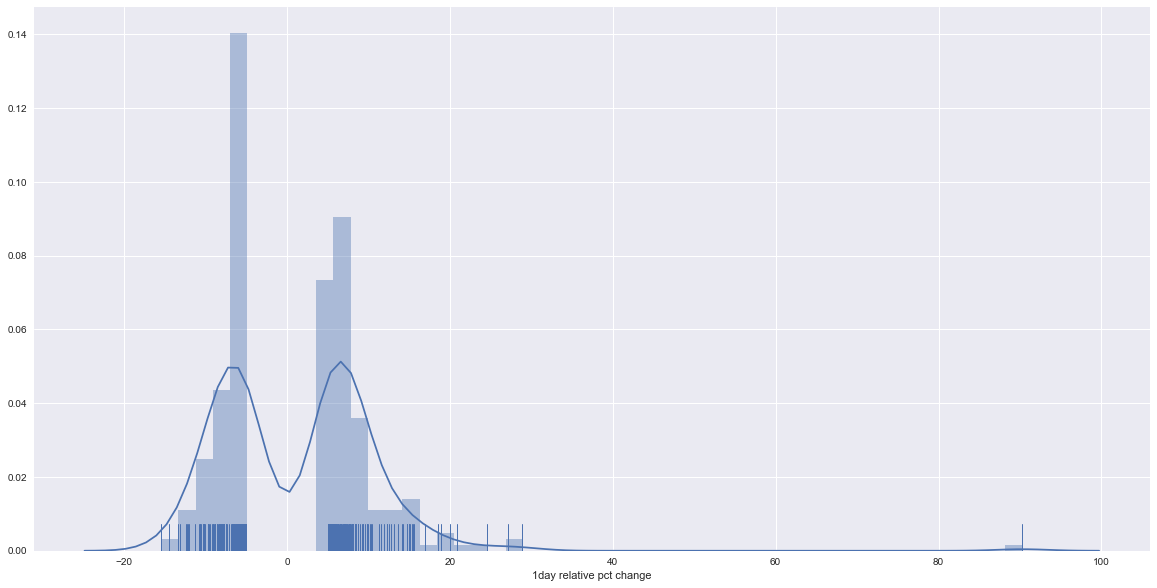

In [8]:
plt.figure(figsize=(20,10))
sns.distplot(filtered_merged_data['1day relative pct change'], bins=50, rug=True)

In [9]:
len(filtered_merged_data)

303

# Create train data and test data

In [10]:
X = filtered_merged_data['rawText']
y = filtered_merged_data['1day pct change']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Tf-Idf

### Load from file

In [12]:
#tfidf = joblib.load('tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

In [13]:
#tfidf_vectors = tfidf.transform(X_train)

### Recreate vectorizer from scratch

In [14]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t.lower(), 'v') for t in word_tokenize(doc)]

In [15]:
tfidf = TfidfVectorizer(max_df=0.4, min_df=5, ngram_range=(1,2),tokenizer=LemmaTokenizer(), stop_words='english')

In [16]:
tfidf_vectors = tfidf.fit_transform(X_train)

In [17]:
#joblib.dump(tfidf, 'tfidf_lemmatokenizer__maxdf0_4__mindf300.pkl')

# DNN model

In [18]:
dense_tfidf_vectors = tfidf_vectors.toarray()

In [19]:
# define base model
def baseline_model():
    model = Sequential()
    model.add(Dense(200, input_dim=dense_tfidf_vectors.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [20]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=10, verbose=2)

In [21]:
'''
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, dense_tfidf_vectors, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
'''

'\nkfold = KFold(n_splits=10)\nresults = cross_val_score(estimator, dense_tfidf_vectors, y_train, cv=kfold)\nprint("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n'

In [22]:
estimator.fit(dense_tfidf_vectors, y_train)

Epoch 1/30
4s - loss: 83.4113
Epoch 2/30
1s - loss: 82.6478
Epoch 3/30
1s - loss: 75.9947
Epoch 4/30
1s - loss: 45.5660
Epoch 5/30
1s - loss: 16.5240
Epoch 6/30
1s - loss: 8.5400
Epoch 7/30
1s - loss: 4.4112
Epoch 8/30
1s - loss: 2.1661
Epoch 9/30
1s - loss: 1.0385
Epoch 10/30
1s - loss: 0.6226
Epoch 11/30
1s - loss: 0.7609
Epoch 12/30
1s - loss: 0.6555
Epoch 13/30
1s - loss: 0.7688
Epoch 14/30
1s - loss: 1.1314
Epoch 15/30
1s - loss: 1.1538
Epoch 16/30
1s - loss: 1.0644
Epoch 17/30
1s - loss: 1.0521
Epoch 18/30
1s - loss: 1.1649
Epoch 19/30
1s - loss: 1.4521
Epoch 20/30
1s - loss: 0.9052
Epoch 21/30
1s - loss: 1.1918
Epoch 22/30
1s - loss: 2.2815
Epoch 23/30
1s - loss: 1.9731
Epoch 24/30
1s - loss: 0.9037
Epoch 25/30
1s - loss: 0.6362
Epoch 26/30
1s - loss: 0.3425
Epoch 27/30
1s - loss: 0.2437
Epoch 28/30
1s - loss: 0.1376
Epoch 29/30
1s - loss: 0.1091
Epoch 30/30
1s - loss: 0.1841


In [23]:
test_vectors = tfidf.transform(X_test)

In [24]:
test_vectors = test_vectors.toarray()

In [25]:
y_predicted = estimator.predict(test_vectors)

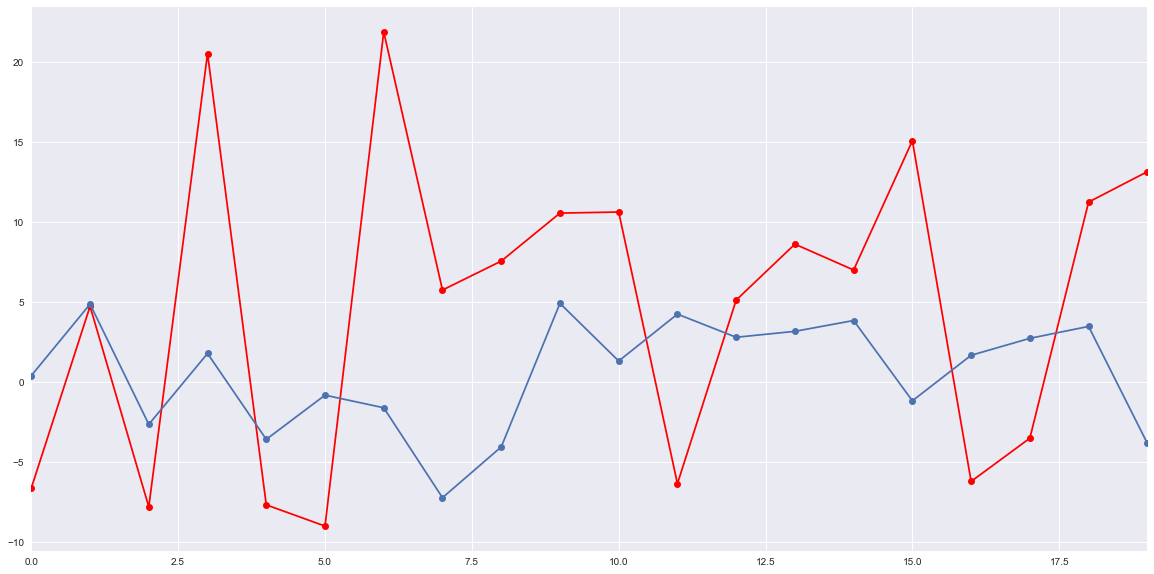

In [26]:
plt.figure(figsize=(20,10))
sns.tsplot(y_test[0:20], color='r', marker='o')
sns.tsplot(y_predicted[0:20], marker='o')

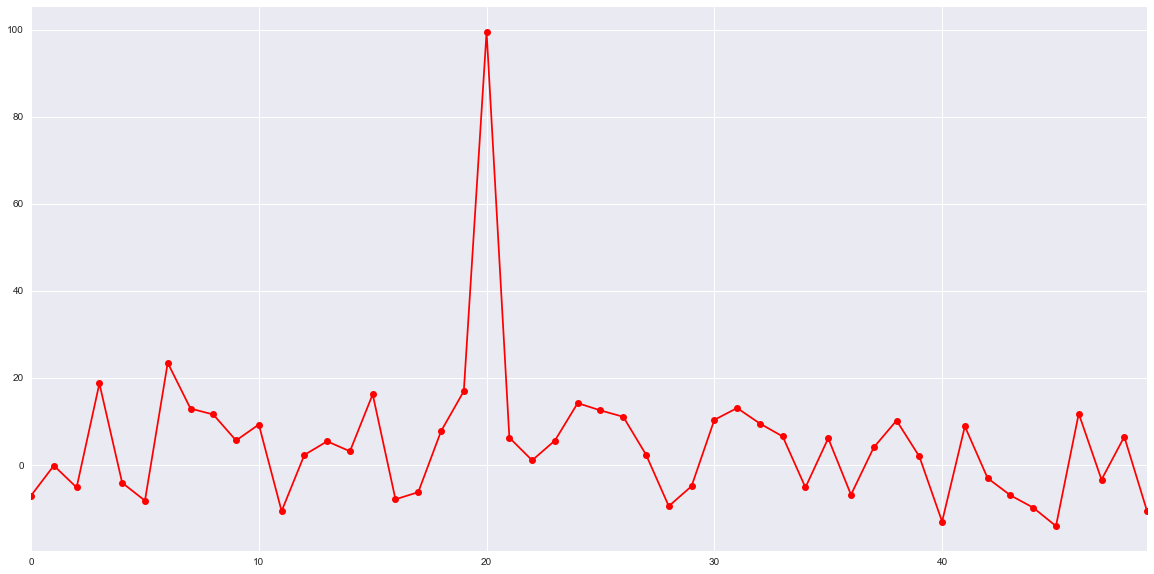

In [27]:
plt.figure(figsize=(20,10))
#sns.tsplot(y_test[0:50])
error = y_test-y_predicted
sns.tsplot(error[0:50], color='r', marker='o')

In [28]:
error_value = mean_squared_error(y_test, y_predicted)

In [29]:
error_value

246.43683607958505

In [30]:
y_test_pos = y_test > 0

In [31]:
y_predicted_pos = y_predicted > 0

In [32]:
diff = y_test_pos != y_predicted_pos

In [33]:
y_predicted_pos[0:5]

array([ True,  True, False,  True, False], dtype=bool)

In [34]:
y_test_pos[0:5]

tradingSymbol  publishDate_str
DAKT           2012-02-21         False
ALK            2008-04-28          True
ALL            2009-01-29         False
AVP            2016-02-11          True
ACET           2016-05-06         False
Name: 1day pct change, dtype: bool

In [35]:
diff[0:5]

tradingSymbol  publishDate_str
DAKT           2012-02-21          True
ALK            2008-04-28         False
ALL            2009-01-29         False
AVP            2016-02-11         False
ACET           2016-05-06         False
Name: 1day pct change, dtype: bool

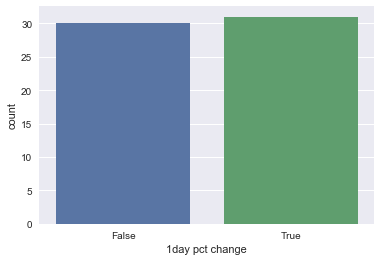

In [36]:
sns.countplot(diff)